In [1]:
import numpy as np
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

In [2]:
import logging
logging.basicConfig(level=logging.INFO, format='[%(asctime)s] %(levelname)s: %(message)s')

In [4]:
# importing  custom particle_net keras model 
!wget https://raw.githubusercontent.com/raeubaen/RadioMonteCarlo/main/tf_keras_model.py -O tf_keras_model.py

--2022-06-19 10:09:36--  https://raw.githubusercontent.com/raeubaen/RadioMonteCarlo/main/tf_keras_model.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6795 (6.6K) [text/plain]
Saving to: ‘tf_keras_model.py’

tf_keras_model.py   100%[===================>]   6.64K  --.-KB/s    in 0s      

2022-06-19 10:09:36 (64.8 MB/s) - ‘tf_keras_model.py’ saved [6795/6795]



In [7]:
import tensorflow as tf
from tensorflow import keras
from tf_keras_model import get_particle_net_lite_custom

Data are imported in .npy format from Dropbox 

In [ ]:
'''
from google.colab import drive
drive.mount('/content/drive')

data_folder = "/content/drive/MyDrive/datiML"
'''

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
!wget https://www.dropbox.com/sh/oqlkgpajx6nu8i7/AABnJFTfOheRs2O3x_NT_q72a?dl=1 -O keras_input.zip
!unzip keras_input.zip

data_folder = "."

--2022-06-19 10:32:21--  https://www.dropbox.com/sh/oqlkgpajx6nu8i7/AABnJFTfOheRs2O3x_NT_q72a?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6025:18::a27d:4512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/dl/oqlkgpajx6nu8i7/AABnJFTfOheRs2O3x_NT_q72a [following]
--2022-06-19 10:32:22--  https://www.dropbox.com/sh/dl/oqlkgpajx6nu8i7/AABnJFTfOheRs2O3x_NT_q72a
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb0f9650dcd34334644e4d1aac2.dl.dropboxusercontent.com/zip_download_get/BK7x6fMlPpq-LjqDVNBoeGDHsuJRVTPyRqHMv28TytfLzcE1-5GxSh8xzY5XwSIT0snFb3Zx7vHQgPUKy4JyIsinfcgt3oeOvOlG85BRP-zr3Q?dl=1# [following]
--2022-06-19 10:32:22--  https://ucb0f9650dcd34334644e4d1aac2.dl.dropboxusercontent.com/zip_download_get/BK7x6fMlPpq-LjqDVNBoeGDHsuJRVTPyRqHMv28TytfLzcE1-5GxSh8xzY5XwSIT0snFb3Zx7v

There are three type of samples:
- Photons from Radiative Muon Capture, as signal
- Min-bias events due to the beam, as background
- Cosmic rays, as background

All the samples represent clusters in the upstream calorimeter disk.

The datasets are saved as dictionaries with 4 components:
-  "points": Point Cloud (xy coordinates of each hit of a cluster) - padded to 50 maximum hits
-  "features": Energy and Time of each hit of a cluster - paddes to 50 maximum hits
-  "mask": Mask to distinguish real hits (the others are filled with 0) in a cluster
-  "summary": Energy, Time, Radius, and Number of active cells for a cluster

In [93]:
name_map = {"points": "xy", "features": "et", "mask": "mask", "summary": "etrn"}

signal  = {key: np.load(f"{data_folder}/signal_{ name_map[key]}.npy") for key in name_map}

mnbs    = {key: np.load(f"{data_folder}/mnbs_{   name_map[key]}.npy") for key in name_map}

cosmics = {key: np.load(f"{data_folder}/cosmics_{name_map[key]}.npy") for key in name_map}

The dataset (generated with Monte Carlo) is weighted to match the real statistics of the data in one Mu2e injection cycle (1.33 s).


In [94]:
'''
cluster su disco upstream in un injection cycle (1.33s):
RMC: 330
MNBS: 1.3M
cosmici: 4

cluster simulati su disco 0:
RMC: 150k
MNBS: 1.05M
cosmici: 53k

pesi:
RMC: 66/150k 
MNBS: 
Cosmici: 4/53k
'''

signal_weight = 330/150e3 * 100
mnbs_weight = 0.24 * 100
cosmics_weight = 4/53e3 * 100

'''
il campione MC è stato filtrato con ROOT
effettuando due tagli di preselezione:
E del cluster > 50 MeV  &&  R del centroide del cluster > 480 mm
'''

print(end="")

The samples are merged into a unique dataset, which is then shuffled, saving also labels and weights

In [95]:
S =  signal["mask"].shape[0] #entries segnale
F =    mnbs["mask"].shape[0] #entries mnbs (background flash da fascio)
C = cosmics["mask"].shape[0] #entries cosmici

N = S + F + C

p = np.random.permutation(N) #

In [96]:
data = {key: np.concatenate( (signal[key], mnbs[key], cosmics[key]) )[p] for key in name_map}

label_list = [1, 0, 0]
entries_list = [S, F, C]
weight_list = [signal_weight, mnbs_weight, cosmics_weight]

print(f"- Entries per signale, mnbs e cosmici:{entries_list}")
print(f"- Pesi per signale, mnbs e cosmici:{weight_list}")

label = np.concatenate( 
    [ np.ones((e))*l for e, l in zip(entries_list,  label_list) ]
)[p]

sample_weight = np.concatenate( 
    [ np.ones((e))*w for e, w in zip(entries_list, weight_list) ]
)[p]

- Entries per signale, mnbs e cosmici:[41372, 1132, 41598]
- Pesi per signale, mnbs e cosmici:[0.22, 24.0, 0.007547169811320755]


The data are normalized to help the training 

In [97]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

for key in ["points", "features"]:
  data[key][data["mask"].reshape(N, 50)] = scaler.fit_transform(data[key][data["mask"].reshape(N, 50)])

data["summary"] = scaler.fit_transform(data["summary"])

The dataset is split in training, validation and test set

In [98]:
train_data  = {key: data[key][int(N*0.0) : int(N*0.7)] for key in name_map}
test_data   = {key: data[key][int(N*0.7) : int(N*0.9)] for key in name_map}
val_data    = {key: data[key][int(N*0.9) : int(N*1.0)] for key in name_map}

train_label = label[int(N*0.0) : int(N*0.7)]
test_label  = label[int(N*0.7) : int(N*0.9)]
val_label   = label[int(N*0.9) : int(N*1.0)]

train_weight = sample_weight[int(N*0.0) : int(N*0.7)]
test_weight  = sample_weight[int(N*0.7) : int(N*0.9)]
val_weight   = sample_weight[int(N*0.9) : int(N*1.0)]

The keras model is imported from the library 

In [99]:
input_shapes = {'points': (50, 2), 'features': (50, 2), 'mask':(50, 1)}

model = get_particle_net_lite_custom(input_shapes)

In [100]:
# Training parameters

batch_size = 1024
epochs = 30

The learning rate is exponentially decreased by a 0.1 factor after 10 epochs and 0.01 after 20 epochs, starting from 0.01 in the first epoch. The best initial learning rate was estimated using the learning rate finder technique (https://colab.research.google.com/github/sachinruk/blog/blob/master/_notebooks/2021-02-15-Tensorflow-Learning-Rate-Finder.ipynb)

In [101]:
def lr_schedule(epoch):
    lr = 1e-2
    if epoch > 10:
        lr *= 0.1
    elif epoch > 20:
        lr *= 0.01
    logging.info('Learning rate: %f'%lr)
    return lr

The model is compiled with:
- Loss: binary crossentropy
- Metrics (weighted to match the real statistics): precision and recall
- Unweighted metrics: accuracy
- Optimizer: Adam

In [102]:
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=lr_schedule(0)),
              weighted_metrics=[keras.metrics.Precision(), keras.metrics.Recall()],
              metrics=['accuracy']
)
model.summary()

[2022-06-19 11:10:46,316] INFO: Learning rate: 0.010000


Model: "ParticleNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mask (InputLayer)              [(None, 50, 1)]      0           []                               
                                                                                                  
 tf.math.not_equal_5 (TFOpLambd  (None, 50, 1)       0           ['mask[0][0]']                   
 a)                                                                                               
                                                                                                  
 tf.cast_10 (TFOpLambda)        (None, 50, 1)        0           ['tf.math.not_equal_5[0][0]']    
                                                                                                  
 tf.math.equal_5 (TFOpLambda)   (None, 50, 1)        0           ['tf.cast_10[0][0]']   

Keras checkpoints are employed to save the model with the best validation accuracy

In [84]:
# Prepare model model saving directory.
import os
save_dir = 'model_checkpoints'
model_name = '%s_model.{epoch:03d}.h5' % "lite"
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
progress_bar = keras.callbacks.ProgbarLogger()
callbacks = [checkpoint, progress_bar, lr_scheduler]

The model is trained and validated, weighting the data to match the real statistics

In [85]:
history = model.fit(
    [train_data["points"], train_data["features"], train_data["mask"], train_data["summary"]], 
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=([val_data["points"], val_data["features"], val_data["mask"], val_data["summary"]], val_label, val_weight),
    shuffle=True,
    sample_weight=train_weight,
    callbacks=callbacks
)

Epoch 1/30


[2022-06-19 11:00:55,200] INFO: Learning rate: 0.010000


      0/Unknown - 10s 0s/sample - loss: 0.1218 - accuracy: 0.6272 - precision_4: 0.8462 - recall_4: 0.6582
Epoch 1: val_accuracy improved from -inf to 0.74082, saving model to model_checkpoints/lite_model.001.h5
58/58 [==============================] - 14s 233ms/sample - loss: 0.1218 - accuracy: 0.6272 - precision_4: 0.8462 - recall_4: 0.6582 - val_loss: 0.1262 - val_accuracy: 0.7408 - val_precision_4: 0.7591 - val_recall_4: 0.7865
Epoch 2/30


[2022-06-19 11:01:08,715] INFO: Learning rate: 0.010000


 0/58 [..............................] - ETA: 0s - loss: 0.0816 - accuracy: 0.7486 - precision_4: 0.8734 - recall_4: 0.8339
Epoch 2: val_accuracy improved from 0.74082 to 0.77149, saving model to model_checkpoints/lite_model.002.h5
58/58 [==============================] - 9s 160ms/sample - loss: 0.0816 - accuracy: 0.7486 - precision_4: 0.8734 - recall_4: 0.8339 - val_loss: 0.0935 - val_accuracy: 0.7715 - val_precision_4: 0.7631 - val_recall_4: 0.7982
Epoch 3/30


[2022-06-19 11:01:18,021] INFO: Learning rate: 0.010000


 0/58 [..............................] - ETA: 0s - loss: 0.0735 - accuracy: 0.7906 - precision_4: 0.8716 - recall_4: 0.8579
Epoch 3: val_accuracy improved from 0.77149 to 0.82987, saving model to model_checkpoints/lite_model.003.h5
58/58 [==============================] - 9s 163ms/sample - loss: 0.0735 - accuracy: 0.7906 - precision_4: 0.8716 - recall_4: 0.8579 - val_loss: 0.1897 - val_accuracy: 0.8299 - val_precision_4: 0.5126 - val_recall_4: 0.9018
Epoch 4/30


[2022-06-19 11:01:27,478] INFO: Learning rate: 0.010000


 0/58 [..............................] - ETA: 0s - loss: 0.0707 - accuracy: 0.8181 - precision_4: 0.8882 - recall_4: 0.8730
Epoch 4: val_accuracy did not improve from 0.82987
58/58 [==============================] - 9s 159ms/sample - loss: 0.0707 - accuracy: 0.8181 - precision_4: 0.8882 - recall_4: 0.8730 - val_loss: 0.0689 - val_accuracy: 0.8095 - val_precision_4: 0.8808 - val_recall_4: 0.8427
Epoch 5/30


[2022-06-19 11:01:36,724] INFO: Learning rate: 0.010000


 0/58 [..............................] - ETA: 0s - loss: 0.0648 - accuracy: 0.8299 - precision_4: 0.9139 - recall_4: 0.8810
Epoch 5: val_accuracy improved from 0.82987 to 0.84378, saving model to model_checkpoints/lite_model.005.h5
58/58 [==============================] - 9s 161ms/sample - loss: 0.0648 - accuracy: 0.8299 - precision_4: 0.9139 - recall_4: 0.8810 - val_loss: 0.1376 - val_accuracy: 0.8438 - val_precision_4: 0.6841 - val_recall_4: 0.9382
Epoch 6/30


[2022-06-19 11:01:46,084] INFO: Learning rate: 0.010000


 0/58 [..............................] - ETA: 0s - loss: 0.0611 - accuracy: 0.8515 - precision_4: 0.8949 - recall_4: 0.8878
Epoch 6: val_accuracy did not improve from 0.84378
58/58 [==============================] - 9s 160ms/sample - loss: 0.0611 - accuracy: 0.8515 - precision_4: 0.8949 - recall_4: 0.8878 - val_loss: 0.0637 - val_accuracy: 0.8357 - val_precision_4: 0.9079 - val_recall_4: 0.8456
Epoch 7/30


[2022-06-19 11:01:55,343] INFO: Learning rate: 0.010000


 0/58 [..............................] - ETA: 0s - loss: 0.0613 - accuracy: 0.8610 - precision_4: 0.8988 - recall_4: 0.8863
Epoch 7: val_accuracy improved from 0.84378 to 0.88467, saving model to model_checkpoints/lite_model.007.h5
58/58 [==============================] - 9s 161ms/sample - loss: 0.0613 - accuracy: 0.8610 - precision_4: 0.8988 - recall_4: 0.8863 - val_loss: 0.0709 - val_accuracy: 0.8847 - val_precision_4: 0.7299 - val_recall_4: 0.9487
Epoch 8/30


[2022-06-19 11:02:04,708] INFO: Learning rate: 0.010000


 0/58 [..............................] - ETA: 0s - loss: 0.0548 - accuracy: 0.8695 - precision_4: 0.9141 - recall_4: 0.9010
Epoch 8: val_accuracy did not improve from 0.88467
58/58 [==============================] - 9s 159ms/sample - loss: 0.0548 - accuracy: 0.8695 - precision_4: 0.9141 - recall_4: 0.9010 - val_loss: 0.0623 - val_accuracy: 0.8777 - val_precision_4: 0.8909 - val_recall_4: 0.9110
Epoch 9/30


[2022-06-19 11:02:13,964] INFO: Learning rate: 0.010000


 0/58 [..............................] - ETA: 0s - loss: 0.0628 - accuracy: 0.8600 - precision_4: 0.8952 - recall_4: 0.8851
Epoch 9: val_accuracy did not improve from 0.88467
58/58 [==============================] - 9s 159ms/sample - loss: 0.0628 - accuracy: 0.8600 - precision_4: 0.8952 - recall_4: 0.8851 - val_loss: 0.0696 - val_accuracy: 0.8526 - val_precision_4: 0.8461 - val_recall_4: 0.9161
Epoch 10/30


[2022-06-19 11:02:23,188] INFO: Learning rate: 0.010000


 0/58 [..............................] - ETA: 0s - loss: 0.0606 - accuracy: 0.8438 - precision_4: 0.8851 - recall_4: 0.8970
Epoch 10: val_accuracy did not improve from 0.88467
58/58 [==============================] - 9s 159ms/sample - loss: 0.0606 - accuracy: 0.8438 - precision_4: 0.8851 - recall_4: 0.8970 - val_loss: 0.0780 - val_accuracy: 0.8654 - val_precision_4: 0.8058 - val_recall_4: 0.9064
Epoch 11/30


[2022-06-19 11:02:32,432] INFO: Learning rate: 0.010000


 0/58 [..............................] - ETA: 0s - loss: 0.0559 - accuracy: 0.8705 - precision_4: 0.9107 - recall_4: 0.9019
Epoch 11: val_accuracy did not improve from 0.88467
58/58 [==============================] - 9s 163ms/sample - loss: 0.0559 - accuracy: 0.8705 - precision_4: 0.9107 - recall_4: 0.9019 - val_loss: 0.0834 - val_accuracy: 0.8815 - val_precision_4: 0.7304 - val_recall_4: 0.9523
Epoch 12/30


[2022-06-19 11:02:41,894] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0523 - accuracy: 0.8741 - precision_4: 0.9050 - recall_4: 0.9171
Epoch 12: val_accuracy improved from 0.88467 to 0.89811, saving model to model_checkpoints/lite_model.012.h5
58/58 [==============================] - 9s 161ms/sample - loss: 0.0523 - accuracy: 0.8741 - precision_4: 0.9050 - recall_4: 0.9171 - val_loss: 0.0567 - val_accuracy: 0.8981 - val_precision_4: 0.8726 - val_recall_4: 0.9441
Epoch 13/30


[2022-06-19 11:02:51,238] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0456 - accuracy: 0.8873 - precision_4: 0.9167 - recall_4: 0.9282
Epoch 13: val_accuracy improved from 0.89811 to 0.90227, saving model to model_checkpoints/lite_model.013.h5
58/58 [==============================] - 9s 161ms/sample - loss: 0.0456 - accuracy: 0.8873 - precision_4: 0.9167 - recall_4: 0.9282 - val_loss: 0.0529 - val_accuracy: 0.9023 - val_precision_4: 0.8727 - val_recall_4: 0.9424
Epoch 14/30


[2022-06-19 11:03:00,605] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0444 - accuracy: 0.8857 - precision_4: 0.9303 - recall_4: 0.9260
Epoch 14: val_accuracy did not improve from 0.90227
58/58 [==============================] - 9s 160ms/sample - loss: 0.0444 - accuracy: 0.8857 - precision_4: 0.9303 - recall_4: 0.9260 - val_loss: 0.0504 - val_accuracy: 0.8887 - val_precision_4: 0.9158 - val_recall_4: 0.9210
Epoch 15/30


[2022-06-19 11:03:09,869] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0440 - accuracy: 0.8882 - precision_4: 0.9270 - recall_4: 0.9275
Epoch 15: val_accuracy did not improve from 0.90227
58/58 [==============================] - 9s 160ms/sample - loss: 0.0440 - accuracy: 0.8882 - precision_4: 0.9270 - recall_4: 0.9275 - val_loss: 0.0494 - val_accuracy: 0.8916 - val_precision_4: 0.9162 - val_recall_4: 0.9251
Epoch 16/30


[2022-06-19 11:03:19,149] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0432 - accuracy: 0.8892 - precision_4: 0.9273 - recall_4: 0.9334
Epoch 16: val_accuracy did not improve from 0.90227
58/58 [==============================] - 9s 160ms/sample - loss: 0.0432 - accuracy: 0.8892 - precision_4: 0.9273 - recall_4: 0.9334 - val_loss: 0.0488 - val_accuracy: 0.8936 - val_precision_4: 0.9163 - val_recall_4: 0.9249
Epoch 17/30


[2022-06-19 11:03:28,427] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0446 - accuracy: 0.8867 - precision_4: 0.9302 - recall_4: 0.9212
Epoch 17: val_accuracy did not improve from 0.90227
58/58 [==============================] - 9s 159ms/sample - loss: 0.0446 - accuracy: 0.8867 - precision_4: 0.9302 - recall_4: 0.9212 - val_loss: 0.0492 - val_accuracy: 0.8969 - val_precision_4: 0.8936 - val_recall_4: 0.9324
Epoch 18/30


[2022-06-19 11:03:37,687] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0431 - accuracy: 0.8931 - precision_4: 0.9274 - recall_4: 0.9281
Epoch 18: val_accuracy did not improve from 0.90227
58/58 [==============================] - 9s 159ms/sample - loss: 0.0431 - accuracy: 0.8931 - precision_4: 0.9274 - recall_4: 0.9281 - val_loss: 0.0508 - val_accuracy: 0.8929 - val_precision_4: 0.8925 - val_recall_4: 0.9207
Epoch 19/30


[2022-06-19 11:03:46,939] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0418 - accuracy: 0.8930 - precision_4: 0.9274 - recall_4: 0.9302
Epoch 19: val_accuracy did not improve from 0.90227
58/58 [==============================] - 9s 160ms/sample - loss: 0.0418 - accuracy: 0.8930 - precision_4: 0.9274 - recall_4: 0.9302 - val_loss: 0.0486 - val_accuracy: 0.8955 - val_precision_4: 0.8931 - val_recall_4: 0.9263
Epoch 20/30


[2022-06-19 11:03:56,206] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0413 - accuracy: 0.8940 - precision_4: 0.9381 - recall_4: 0.9318
Epoch 20: val_accuracy did not improve from 0.90227
58/58 [==============================] - 9s 159ms/sample - loss: 0.0413 - accuracy: 0.8940 - precision_4: 0.9381 - recall_4: 0.9318 - val_loss: 0.0476 - val_accuracy: 0.8959 - val_precision_4: 0.8932 - val_recall_4: 0.9270
Epoch 21/30


[2022-06-19 11:04:05,431] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0426 - accuracy: 0.8913 - precision_4: 0.9342 - recall_4: 0.9260
Epoch 21: val_accuracy did not improve from 0.90227
58/58 [==============================] - 9s 162ms/sample - loss: 0.0426 - accuracy: 0.8913 - precision_4: 0.9342 - recall_4: 0.9260 - val_loss: 0.0490 - val_accuracy: 0.8991 - val_precision_4: 0.8937 - val_recall_4: 0.9324
Epoch 22/30


[2022-06-19 11:04:14,845] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0418 - accuracy: 0.8946 - precision_4: 0.9346 - recall_4: 0.9325
Epoch 22: val_accuracy did not improve from 0.90227
58/58 [==============================] - 9s 162ms/sample - loss: 0.0418 - accuracy: 0.8946 - precision_4: 0.9346 - recall_4: 0.9325 - val_loss: 0.0478 - val_accuracy: 0.8944 - val_precision_4: 0.9163 - val_recall_4: 0.9229
Epoch 23/30


[2022-06-19 11:04:24,234] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0410 - accuracy: 0.8943 - precision_4: 0.9310 - recall_4: 0.9296
Epoch 23: val_accuracy improved from 0.90227 to 0.90477, saving model to model_checkpoints/lite_model.023.h5
58/58 [==============================] - 9s 162ms/sample - loss: 0.0410 - accuracy: 0.8943 - precision_4: 0.9310 - recall_4: 0.9296 - val_loss: 0.0495 - val_accuracy: 0.9048 - val_precision_4: 0.8724 - val_recall_4: 0.9380
Epoch 24/30


[2022-06-19 11:04:33,642] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0400 - accuracy: 0.8978 - precision_4: 0.9314 - recall_4: 0.9350
Epoch 24: val_accuracy did not improve from 0.90477
58/58 [==============================] - 9s 161ms/sample - loss: 0.0400 - accuracy: 0.8978 - precision_4: 0.9314 - recall_4: 0.9350 - val_loss: 0.0478 - val_accuracy: 0.8972 - val_precision_4: 0.8932 - val_recall_4: 0.9261
Epoch 25/30


[2022-06-19 11:04:42,993] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0419 - accuracy: 0.8949 - precision_4: 0.9172 - recall_4: 0.9297
Epoch 25: val_accuracy did not improve from 0.90477
58/58 [==============================] - 9s 159ms/sample - loss: 0.0419 - accuracy: 0.8949 - precision_4: 0.9172 - recall_4: 0.9297 - val_loss: 0.0467 - val_accuracy: 0.8983 - val_precision_4: 0.8932 - val_recall_4: 0.9258
Epoch 26/30


[2022-06-19 11:04:52,238] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0400 - accuracy: 0.8964 - precision_4: 0.9348 - recall_4: 0.9330
Epoch 26: val_accuracy improved from 0.90477 to 0.90584, saving model to model_checkpoints/lite_model.026.h5
58/58 [==============================] - 9s 161ms/sample - loss: 0.0400 - accuracy: 0.8964 - precision_4: 0.9348 - recall_4: 0.9330 - val_loss: 0.0472 - val_accuracy: 0.9058 - val_precision_4: 0.9177 - val_recall_4: 0.9373
Epoch 27/30


[2022-06-19 11:05:01,587] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0417 - accuracy: 0.8952 - precision_4: 0.9274 - recall_4: 0.9270
Epoch 27: val_accuracy improved from 0.90584 to 0.90917, saving model to model_checkpoints/lite_model.027.h5
58/58 [==============================] - 9s 161ms/sample - loss: 0.0417 - accuracy: 0.8952 - precision_4: 0.9274 - recall_4: 0.9270 - val_loss: 0.0479 - val_accuracy: 0.9092 - val_precision_4: 0.8950 - val_recall_4: 0.9421
Epoch 28/30


[2022-06-19 11:05:10,928] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0394 - accuracy: 0.8987 - precision_4: 0.9384 - recall_4: 0.9325
Epoch 28: val_accuracy improved from 0.90917 to 0.91059, saving model to model_checkpoints/lite_model.028.h5
58/58 [==============================] - 9s 161ms/sample - loss: 0.0394 - accuracy: 0.8987 - precision_4: 0.9384 - recall_4: 0.9325 - val_loss: 0.0483 - val_accuracy: 0.9106 - val_precision_4: 0.8529 - val_recall_4: 0.9487
Epoch 29/30


[2022-06-19 11:05:20,291] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0419 - accuracy: 0.8962 - precision_4: 0.9206 - recall_4: 0.9278
Epoch 29: val_accuracy did not improve from 0.91059
58/58 [==============================] - 9s 159ms/sample - loss: 0.0419 - accuracy: 0.8962 - precision_4: 0.9206 - recall_4: 0.9278 - val_loss: 0.0579 - val_accuracy: 0.8725 - val_precision_4: 0.9126 - val_recall_4: 0.8823
Epoch 30/30


[2022-06-19 11:05:29,555] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0402 - accuracy: 0.8971 - precision_4: 0.9384 - recall_4: 0.9336
Epoch 30: val_accuracy did not improve from 0.91059
58/58 [==============================] - 9s 159ms/sample - loss: 0.0402 - accuracy: 0.8971 - precision_4: 0.9384 - recall_4: 0.9336 - val_loss: 0.0479 - val_accuracy: 0.9052 - val_precision_4: 0.8723 - val_recall_4: 0.9365


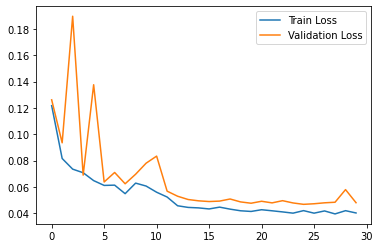

In [86]:
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.legend()

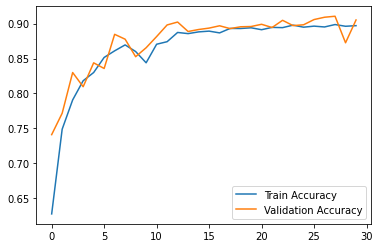

In [88]:
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.legend()

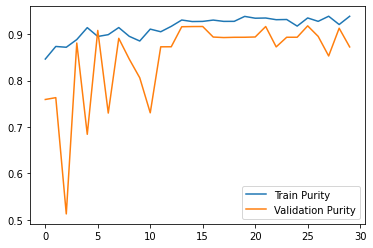

In [87]:
plt.plot(history.history['precision_4'], label="Train Purity")
plt.plot(history.history['val_precision_4'], label="Validation Purity")
plt.legend()

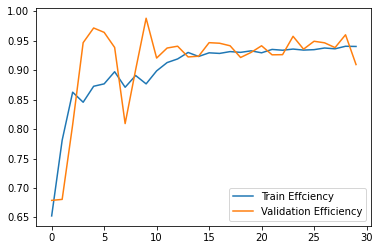

In [58]:
plt.plot(history.history['recall_3'], label="Train Effciency")
plt.plot(history.history['val_recall_3'], label="Validation Efficiency")
plt.legend()

In [89]:
! ls -1rt model_checkpoints/*model*.h5 | tail -n 1
!cp $(ls -1rt model_checkpoints/*model*.h5 | tail -n 1) model_checkpoints/last.h5

model_checkpoints/lite_model.028.h5


In [90]:
model.load_weights("model_checkpoints/last.h5")

In [91]:
probs = model.predict_on_batch(test_data)

0.9639720612519779


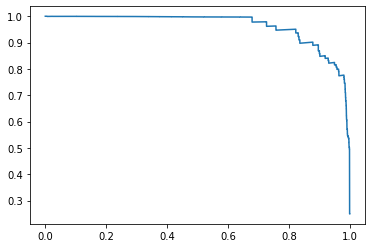

In [92]:
precision, recall, thresholds = precision_recall_curve(test_label, probs, sample_weight=test_weight)
plt.plot(recall, precision)
print(auc(recall, precision))